As always, import the necessary libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

# custom functions for data preparation
import ex1_functions as ff

import warnings
warnings.filterwarnings('ignore')

# Supervised learning

In this notebook, we will train a Random Forest Classifier on the soccer data we handled in the notebook *1_Analysis_and_Cleaning*.

First, we import the numeric data we prepared:

In [25]:
df = pd.read_csv('data/players_with features_no_nan_only_num_values.csv')
df.head(3)

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_colour,gravity,meanIAT_yellowCards,meanIAT_yellowReds,meanIAT_redCards,meanIAT_gravity,meanExp_yellowCards,meanExp_yellowReds,meanExp_redCards,meanExp_gravity
0,177.0,72.0,144.0,65.0,32.0,47.0,10.0,21.0,1.0,2.0,0.375,116.674213,0.058858,0.000535,0.001203,0.114196,0.093395,0.001087,0.002447,0.205938
1,179.0,82.0,427.0,183.0,101.0,143.0,88.0,33.0,0.0,2.0,0.750,95.589050,0.020451,0.000000,0.001752,0.075289,0.013638,0.000000,-0.000520,-0.002640
2,182.0,71.0,654.0,247.0,179.0,228.0,9.0,19.0,0.0,0.0,0.125,19.000000,0.011768,0.000000,0.000000,0.011768,0.018965,0.000000,0.000000,0.018965


## Which classification?
Remember, the *skin_colour* column is actually the average rating over the two raters. Let's bring up its values:

In [26]:
df.skin_colour.unique()

array([ 0.375,  0.75 ,  0.125,  1.   ,  0.25 ,  0.   ,  0.5  ,  0.875,
        0.625])

As it stands, there are 9 values that encode skin colour. 

### Assumption
We make the choice to reduce these values to only two categories, which we believe are enough to roughly determine a person's skin colour. Thus, we reduce our problem to binary classification.

## First set of features

As a test, we train a random forest on all the features of our data that have a link to player-referee interactions, and thus may contain a hint of racism.

In [27]:
# comment out the features you want to pass to the classifier!
cols = ['height', 
        'weight', 
        'games', 
        'victories', 
        'ties', 
        'defeats', 
        'goals', 
        #'yellowCards',
        #'yellowReds',
        #'redCards',
        'skin_colour', 
        #'gravity',
        #'meanIAT_yellowCards',
        #'meanIAT_yellowReds', 
        #'meanIAT_redCards',
        #'meanIAT_gravity',
        #'meanExp_yellowCards',
        #'meanExp_yellowReds', 
        #'meanExp_redCards',
        #'meanExp_gravity'
       ]

We prepare our data in the correct format with the help of functions stored in *1_functions.py*.

In [28]:
# choose the appropriate separator for skin_colour
b = ff.binary_separator
# transform the df into np matrix
data, target, labels = ff.prepare_data(df, cols, b)

df shape: (1419, 20)
data shape: (1419, 12)
target shape: (1419,)


Let's check if there is any class imbalance:

In [29]:
x = df.skin_colour.apply(ff.binary_separator)

In [30]:
x.value_counts()

0    1192
1     227
Name: skin_colour, dtype: int64

As it turns out, there is a huge class imbalance. We will see later wether it's a problem for us.

### Setting the parameters
One parameter we're interested in when instantiating a random forest is its number of estimators. 

Thus, we iterate over a number of forests with a different number of estimators and use the OOB score to figure out how many estimators is enough. Our *ff.train_test_RF()* function performs a train/test split on the data to train the random forest. It also holds some data out of the train/test samples, to perform a check on data the classifier hasn't seen before.

In [ ]:
oob = []
for i in range(5, 200, 1):
    forest = RandomForestClassifier(n_estimators = i, max_features=0.33, max_depth=10, n_jobs=-1, oob_score=True);
    forest = ff.train_test_RF(forest, data, target, 150);
    oob.append(1-forest.oob_score_);
    #print('oob: '+str(forest.oob_score_))
    #print(' ')

In [ ]:
plt.plot(range(5, 200, 1), oob, '-')

As we can see, although it is still rough, the error starts to stabilise at around 50 estimators. To be safe, we'll use *n_estimators = 100*.

We do the same to set the depth parameter. This time, we use the accuracy score on the held-out sample.

In [20]:
acc = []
for i in range(1, 50, 1):
    forest = RandomForestClassifier(n_estimators = 100, max_features=0.33, max_depth=i, n_jobs=-1, oob_score=True);
    forest, accuracy = ff.train_test_RF(forest, data, target, 150);
    acc.append(1-accuracy);
    #print('oob: '+str(forest.oob_score_))
    #print(' ')

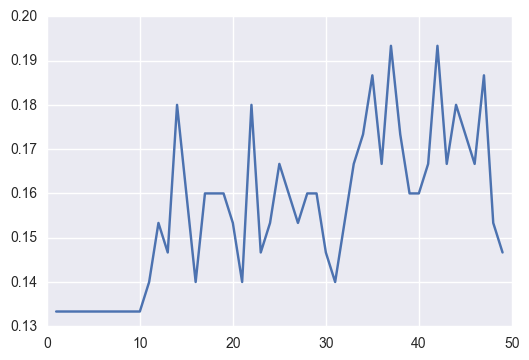

In [21]:
plt.plot(range(1, 50, 1), acc, '-')

Here we see that it seems better to have a *max_depth* of only 10 and not more. Thus we will set it at 10.

### Cross-validation

We fit our random forest classifier using cross-validation, so as to avoid overfitting. We use KFold.

In [41]:
forest = RandomForestClassifier(n_estimators = 100, max_features=0.33, max_depth=10, n_jobs=-1)
kf = KFold(n_splits=20)
for train, test in kf.split(data):
    forest.fit(data[train], target[train])

In [42]:
imp = forest.feature_importances_

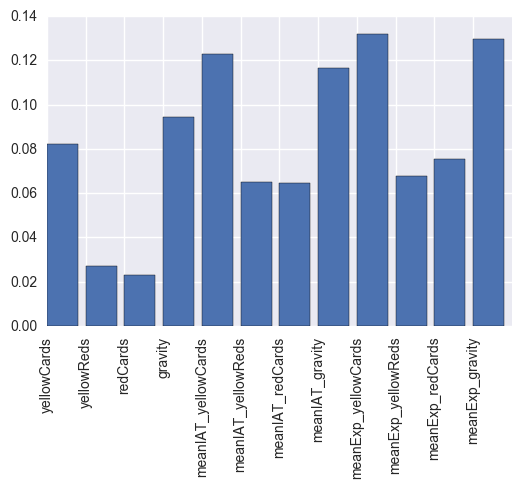

In [43]:
ff.impo_graph(imp, labels)

## Second set of features

In [ ]:
# comment out the features you want to pass to the classifier!
cols = [#'height', 
        #'weight', 
        #'games', 
        #'victories', 
        #'ties', 
        #'defeats', 
        #'goals', 
        'skin_colour', 
        'yellowCards',
        'yellowReds', 
        'redCards',
        'gravity', 
        'meanIAT_yellowReds', 
        'meanIAT_redCards', 
        'meanExp_yellowReds', 
        'meanExp_redCards',
        'meanIAT_yellowCards', 
        'meanIAT_gravity',
        'meanExp_yellowCards', 
        'meanExp_redCards', 
        'meanExp_gravity'
       ]

In [ ]:
b = ff.separator
data, target, labels = ff.prepare_data(df, cols, b)

In [ ]:
forest2 = RandomForestClassifier(n_estimators = 100)

In [ ]:
forest2 = ff.train_test_RF(forest2, data, target, 150)

We note here something quite disappointing: the results are almost the same, although we did not use any racism information.

In [ ]:
imp2 = forest2.feature_importances_

In [ ]:
ff.impo_graph(imp2, labels)

In [ ]:
from sklearn.cross_validation import cross_val_score

In [ ]:
f = RandomForestClassifier(n_estimators = 100)

In [ ]:
scores = cross_val_score(f, data, target, cv=30, scoring='accuracy')

In [ ]:
f.feature_importances_

In [ ]:
scores

idea: use a hold-out sample

In [ ]:
scores.mean()

Heavily inspired by http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = data, target


title = "Learning Curves (RF Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(n_estimators=100)
plot_learning_curve(estimator, title, X, y, ylim=(-3, 3), cv=cv, n_jobs=1)

plt.show()